In [154]:
%load_ext autoreload
%autoreload 2
%pylab inline

from itertools import product as iter_prod
from time import time
from typing import Callable, Dict, Tuple, Type
import warnings

import cvxopt
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import clone, BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import seaborn as sns

sns.set(style='ticks', context='talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'colors', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part 1

## Assignment 1

In [57]:
class SupervisedMethod:
    def __init__(self, *args, **kwargs) -> 'SupervisedMethod':
        self._cvloss = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'SupervisedMethod':
        raise NotImplementedError()

    def predict(X: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @property
    def cvloss(self):
        return self._cvloss

    @cvloss.setter
    def cvloss(self, val):
        self._cvloss = val

def make_kernel(kernel_name, kp=None):
    if kernel_name == 'linear':
        if kp is None:
            kp = 0
        def linear_kernel(x, y):
            return np.inner(x, y) + kp
        return linear_kernel
    elif kernel_name == 'polynomial':
        if kp is None:
            kp = 1
        def poly_kernel(x, y):
            return (np.inner(x, y) + 1)**kp
        return poly_kernel
    elif kernel_name == 'gaussian':
        if kp is None:
            kp = 1
        def gauss_kernel(x, y):
            return np.exp(-cdist(x, y, 'sqeuclidean')/(2*kp))
        return gauss_kernel
    else:
        raise ValueError(f"kernel '{kernel_name}' not recognized")


In [85]:
class svm_smo(SupervisedMethod, BaseEstimator):
    def __init__(self, kernel=None, kernel_name=None, C=1,
                 kernelparameter=None, max_passes=10, tolerance=1e-4,
                 max_iterations=None):
        assert kernel is None or kernel_name is None
        if kernel_name is None:
            kernel_name = kernel
        self.params = {
            'max_iterations': max_iterations,
            'kernel_name': kernel_name,
            'kernelparameter': kernelparameter,
            'C': C,
            'max_passes': max_passes,
            'tolerance': tolerance
        }
        self.set_params(**self.params)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        if 'max_iterations' in params:
            self.max_iterations = params['max_iterations']
        else:
            self.max_iterations = None

        self.kernel_name = params['kernel_name']

        if 'kernelparameter' in params:
            self.kernelparameter = params['kernelparameter']
        else:
            self.kernelparameter = None
        self.kernelf = make_kernel(params['kernel_name'],
                                   self.kernelparameter)
        self.C = params['C']

        if 'max_passes' in params:
            self.max_passes = params['max_passes']
        else:
            self.max_passes = 10

        if 'tolerance' in params:
            self.tolerance = params['tolerance']
        else:
            self.tolerance = 1e-4
        self.support_vectors = None
        self.support_y = None
        self.alpha = None
        self.b = None

        self.params = params
        return self

    def fit(self, X, Y=None, y=None):
        assert Y is not None or y is not None
        max_iterations = self.max_iterations
        if max_iterations is None:
            max_iterations = self.max_passes * 10
        if y is None:
            y = Y
        N, M = X.shape

        self.support_vectors = X
        self.support_y = y
        C = self.C
        tol = self.tolerance

        K = self.kernelf(X, X)
        self.alpha = np.zeros(N)
        self.b = 0
        passes = 0
        indeces = np.arange(N)
        for _ in range(max_iterations):
            if passes >= self.max_passes:
                break
            params_updated = False
            for i in indeces:
                E_i = self._project(X[i]) - y[i]
                if ((y[i]*E_i < -tol and self.alpha[i] < C) or
                        (y[i]*E_i > tol and self.alpha[i] > 0)):
                    j = np.random.choice(indeces[indeces != i], 1)
                    E_j = self.predict(X[j]) - y[j]
                    self.alpha, self.b, updated =\
                        self._update_parameters(E_i, E_j, i, j,
                                                K, y, self.alpha,
                                                self.b, C)
                    params_updated |= updated
            if params_updated:
                passes = 0
            else:
                passes += 1

        self.support_vectors = X[self.alpha != 0].copy()
        self.support_y = y[self.alpha != 0].copy()
        self.alpha = self.alpha[self.alpha != 0]
        return self

    def _project(self, X):
        X = np.atleast_2d(X)
        return (self.kernelf(X, self.support_vectors) *
                self.support_y *
                self.alpha).sum(axis=1) - self.b

    def predict(self, X):
        return np.sign(self._project(X))

    def _compute_box_constraints(self, i, j, y, alpha, C):
        if y[i] == y[j]:
            L = max(0, alpha[i] + alpha[j] - C)
            H = min(C, alpha[i] + alpha[j])
        else:
            L = max(0, alpha[j] - alpha[i])
            H = min(C, C + alpha[j] - alpha[i])
        return L, H

    def _compute_updated_b(self, E_i, E_j, i, j, K, y, alpha_old,
                           alpha_new, b_old, C):
        b_1 = (b_old + E_i +
               y[i]*(alpha_new[i] - alpha_old[i])*K[i, i] +
               y[j]*(alpha_new[j] - alpha_old[j])*K[i, j])

        b_2 = (b_old + E_j +
               y[i]*(alpha_new[i] - alpha_old[i])*K[i, j] +
               y[j]*(alpha_new[j] - alpha_old[j])*K[j, j])

        if 0 < alpha_new[i] < C:
            b_new = b_1
        elif 0 < alpha_new[j] < C:
            b_new = b_2
        else:
            b_new = (b_1 + b_2)/2
        return b_new

    def _update_parameters(self, E_i, E_j, i, j, K, y, alpha, b, C):
        L, H = self._compute_box_constraints(i=i, j=j, y=y,
                                             alpha=alpha, C=C)
        if L == H:
            return alpha, b, False

        kappa = 2*K[i, j] - K[i, i] - K[j, j]
        if kappa >= 0:
            return alpha, b, False

        alpha_new = alpha.copy()

        alpha_new_j = alpha[j] - y[j]*(E_i - E_j)/kappa
        if alpha_new_j > H:
            alpha_new[j] = H
        elif alpha_new_j < L:
            alpha_new[j] = L
        else:
            alpha_new[j] = alpha_new_j

        alpha_new[i] = alpha[i] + y[i]*y[j]*(alpha[j] - alpha_new[j])

        if np.abs(alpha[j] - alpha_new[j]) < 1e-5:
            return alpha, b, False

        b_new = self._compute_updated_b(E_i=E_i, E_j=E_j, i=i, j=j,
                                        K=K, y=y, alpha_old=alpha,
                                        alpha_new=alpha_new, b_old=b, C=C)

        return alpha_new, b_new, True


## Assignment 2

In [5]:
def plot_svm_2d(X, y, model, ax=None):
    show_plot = False
    if ax is None:
        ax = plt.figure().gca()
        show_plot = True

    colors = sns.color_palette()
    ax.scatter(*X[y == 1].T, c=colors[0], alpha=0.7)
    ax.scatter(*X[y == -1].T, c=colors[1], alpha=0.7)
    ax.scatter(*model.support_vectors[model.support_y == 1].T,
               marker='+', c=colors[0], s=150)
    ax.scatter(*model.support_vectors[model.support_y == -1].T,
               marker='+', c=colors[1], s=150)

    num = 300
    x = np.linspace(*ax.get_xlim(), num=num)
    y = np.linspace(*ax.get_ylim(), num=num)
    X, Y = np.meshgrid(x, y)
    Z = np.r_['0,2', X.flatten(), Y.flatten()].T
    Z = model.predict(Z).reshape(num, num)
    ax.contour(X, Y, Z, colors=[colors[2]], alpha=0.5)
    sns.despine()
    plt.tight_layout()

    if show_plot:
        plt.show()
        plt.savefig('assignment2.png')


## Assignment 3

In [161]:
class svm_qp(SupervisedMethod, BaseEstimator):
    def __init__(self, kernel=None, kernel_name=None, C=1,
                 kernelparameter=None):
        assert kernel is None or kernel_name is None
        if kernel_name is None:
            kernel_name = kernel
        self.params = {
            'kernel_name': kernel_name,
            'kernelparameter': kernelparameter,
            'C': C,
        }
        self.set_params(**self.params)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.kernel_name = params['kernel_name']

        if 'kernelparameter' in params:
            self.kernelparameter = params['kernelparameter']
        else:
            self.kernelparameter = None
        self.kernelf = make_kernel(params['kernel_name'],
                                   self.kernelparameter)
        self.C = params['C']

        self.support_vectors = None
        self.support_y = None
        self.alpha = None
        self.b = None

        self.params = params
        return self

    def get_qp_matrices(self, K, y):
        N = len(y)
        P = np.outer(y, y) * K
        q = -np.ones(N)
        G = np.vstack((np.eye(N), -np.eye(N)))
        h = np.vstack((np.zeros((N, 1)) + self.C, np.zeros((N, 1))))

        P = cvxopt.matrix(P, tc='d')
        q = cvxopt.matrix(q, (N, 1), tc='d')
        G = cvxopt.matrix(G, tc='d')
        h = cvxopt.matrix(h, tc='d')
        A = cvxopt.matrix(y, (1, N), tc='d')
        b = cvxopt.matrix(0, tc='d')
        return P, q, G, h, A, b

    def fit(self, X, Y=None, y=None):
        assert Y is not None or y is not None
        if y is None:
            y = Y
        N, M = X.shape
        K = self.kernelf(X, X)
        P, q, G, h, A, b = self.get_qp_matrices(K, y)

        show_progress = cvxopt.solvers.options.get('show_progress', True)
        cvxopt.solvers.options['show_progress'] = False
        try:
            alpha = np.array(cvxopt.solvers.qp(P, q, G, h, A, b)['x'])
            alpha = alpha.flatten()
        except ValueError as e:
            print(e)
            alpha = np.zeros_like(y)
            alpha[0] += 1
        cvxopt.solvers.options['show_progress'] = show_progress

        support_indexes = alpha > 1e-6
        self.alpha = alpha[support_indexes]
        self.support_vectors = X[support_indexes].copy()
        self.support_y = y[support_indexes].copy()

        SV = (alpha > 1e-6)
        uSV = SV * (alpha < self.C - 1e-6)
        self.b = -1.0/sum(uSV)*(y[uSV] - K[uSV, :] @ (alpha*y)).sum()

    def predict(self, X):
        X = np.atleast_2d(X)
        return np.sign(
                (self.kernelf(X, self.support_vectors) *
                 self.support_y *
                 self.alpha).sum(axis=1) - self.b
        )

# Part 2

## Assignment 4

In [126]:
def zero_one_loss(y_true: np.ndarray,
                  y_pred: np.ndarray) -> float:
    return 1 - (y_true == y_pred).mean()


def params_prod(params):
    return (dict(zip(params, x))
            for x in iter_prod(*params.values()))


def cv_instance(i, params, X, y,
                method, nrepetitions, nfolds,
                loss_function):
    N, M = X.shape
    fold_size = int(np.ceil(N/nfolds))

    print(f"Parameter iteration nr: {i+1}.")

    loss = 0
    for j in range(nrepetitions):
        indexes = np.random.choice(np.arange(N, dtype=int),
                                   size=N, replace=False)
        folds = [indexes[j: j+fold_size]
                 for i in range(0, N, fold_size)]

        for k, fold in enumerate(folds):
            idx_train = [fold for l, fold in enumerate(folds)
                         if l != k]
            idx_train = np.r_[idx_train].flatten()
            X_train = X[idx_train]
            y_train = y[idx_train]
            X_val = X[fold]
            y_val = y[fold]
            model = method(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            loss += loss_function(y_val, y_pred)
    loss /= nfolds*nrepetitions
    print(f"Parameter iteration nr: {i+1}.")
    print(f"Params: {params}")
    print(f"Loss: {loss}")
    print()
    return loss, params


def cv(X: np.ndarray,
       y: np.ndarray,
       method: Type[SupervisedMethod],
       parameters: Dict,
       nrepetitions=5,
       nfolds: int=10,
       loss_function: Callable[[np.ndarray, np.ndarray],
                               float]=zero_one_loss,
       seed: int=None)\
        -> Tuple[Dict, float]:
    assert len(X) == len(y)
    N, M = X.shape
    if seed is not None:
        np.random.seed(seed)

    best_params = None
    best_loss = np.inf

    results = Parallel(n_jobs=-1)(delayed(cv_instance)
                                  (i, params, X, y, method, nrepetitions,
                                   nfolds, loss_function)
                                  for i, params
                                  in enumerate(params_prod(parameters)))

    best_loss, best_params = sorted(results, key=lambda r: r[0])[0]
    print(f"Best Loss: {best_loss}")
    print(f"Best Params: {best_params}")

    return best_params, best_loss


def auc(y_true, X, model, B, plot=False, ax=None, label=None):
    y_true: np.ndarray = y_true == 1

    tpr = np.zeros_like(B)
    fpr = np.zeros_like(B)
    original_b = model.b
    for i, b in enumerate(B):
        model.b = np.atleast_1d(b)
        y_pred = model.predict(X)
        y_pred: np.ndarray = y_pred == 1
        tp = (y_pred & y_true).sum()
        fp = (y_pred & ~y_true).sum()
        tpr[i] = tp / len(y_true[y_true])
        fpr[i] = fp / len(y_true[~y_true])
    model.b = original_b

    if plot:
        show_fig = False
        if ax is None:
            ax = plt.figure(figsize=(8, 8)).gca()
            show_fig = True
        ax.plot(fpr, tpr, label=label)
        ax.plot(*np.r_['0,2', 0:2, 0:2], 'r--', label='Random Guess')
        ax.set_ylim(0, 1.1)
        ax.set_ylabel("True positive rate")
        ax.set_xlim(0, 1.1)
        ax.set_xlabel("False positive rate")
        sns.despine(trim=True)
        if show_fig:
            plt.show()
            plt.savefig('roc_curve.png')

    print(tpr)
    print(fpr)
    c = np.trapz(tpr, fpr)
    return c

### Point 1.

In [106]:
easy_2d = np.load('./easy_2d.npz')
X_train = easy_2d['X_tr'].T
y_train = easy_2d['Y_tr']
X_test = easy_2d['X_te'].T
y_test = easy_2d['Y_te']

X_train = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test = (X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))
X_train = X_train - X_train.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

In [112]:
parameters = {
    'kernel_name': ['gaussian'],
    'C': np.logspace(-2, 4, 12),
    'kernelparameter': np.logspace(-3, 3, 12)
}
gs = GridSearchCV(svm_smo('gaussian'), parameters, cv=10,
                  scoring=lambda m, X, y: -zero_one_loss(y, m.predict(X)),
                  verbose=1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 16.5min finished


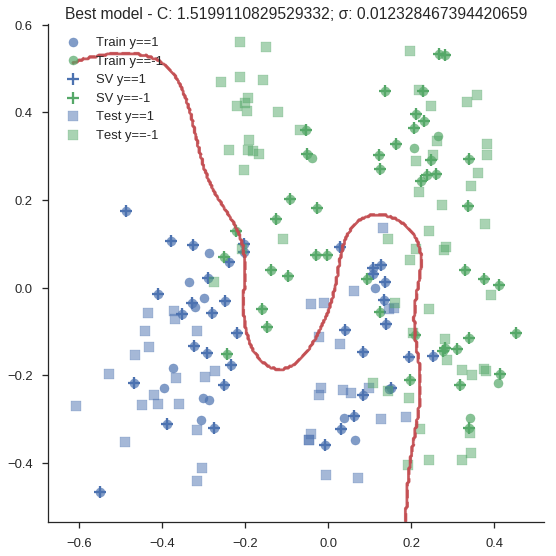

In [118]:
ax = plt.figure(figsize=(8, 8)).gca()
plot_svm_2d(X=X_train, y=y_train, model=best_model, ax=ax)
colors = sns.color_palette()
ax.scatter(*X_test[y_test == 1].T, c=colors[0], alpha=0.5, marker='s')
ax.scatter(*X_test[y_test == -1].T, c=colors[1], alpha=0.5, marker='s')
ax.legend(['Train y==1', 'Train y==-1', 'SV y==1', 'SV y==-1',
            'Test y==1', 'Test y==-1'])
ax.set_title(f"Best model - C: {best_model.C}; σ: {best_model.kernelparameter}")
plt.tight_layout()

### Point 2.

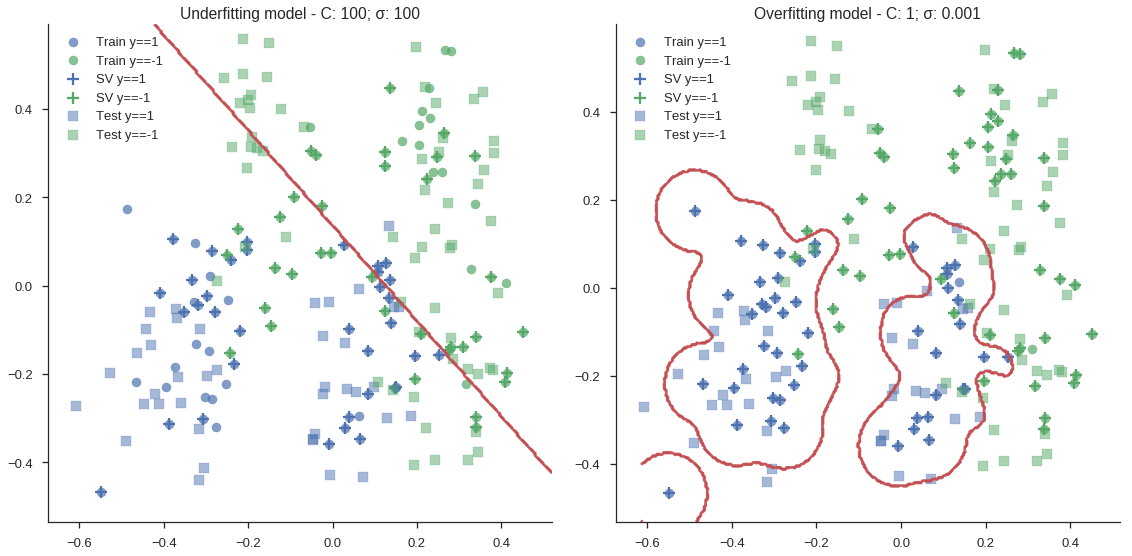

In [119]:
C_u, σ_u = 100, 100
underfit_model = svm_smo(kernel='gaussian', C=C_u, kernelparameter=σ_u)
underfit_model.fit(X_train, y_train)

C_o, σ_o = 1, 0.001
overfit_model = svm_smo(kernel='gaussian', C=C_o, kernelparameter=σ_o)
overfit_model.fit(X_train, y_train)

_, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes.flatten()

plot_svm_2d(X=X_train, y=y_train, model=underfit_model, ax=ax1)
colors = sns.color_palette()
ax1.scatter(*X_test[y_test == 1].T, c=colors[0], alpha=0.5, marker='s')
ax1.scatter(*X_test[y_test == -1].T, c=colors[1], alpha=0.5, marker='s')
ax1.legend(['Train y==1', 'Train y==-1', 'SV y==1', 'SV y==-1',
            'Test y==1', 'Test y==-1'])
ax1.set_title(f"Underfitting model - C: {C_u}; σ: {σ_u}")

plot_svm_2d(X=X_train, y=y_train, model=overfit_model, ax=ax2)
colors = sns.color_palette()
ax2.scatter(*X_test[y_test == 1].T, c=colors[0], alpha=0.5, marker='s')
ax2.scatter(*X_test[y_test == -1].T, c=colors[1], alpha=0.5, marker='s')
ax2.legend(['Train y==1', 'Train y==-1', 'SV y==1', 'SV y==-1',
            'Test y==1', 'Test y==-1'])
ax2.set_title(f"Overfitting model - C: {C_o}; σ: {σ_o}")
plt.tight_layout()

### Point 3.

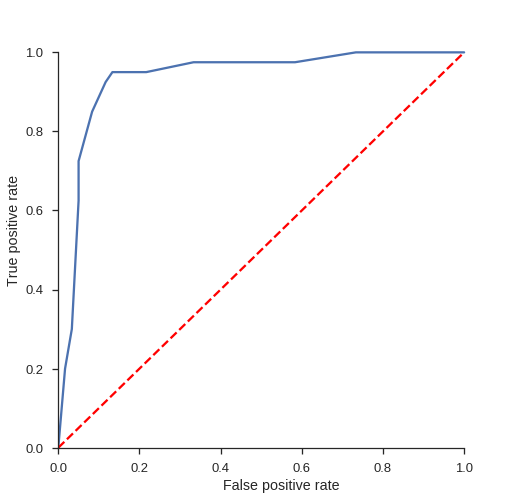

-0.93500000000000005

In [120]:
auc(y_test, X_test, best_model, np.linspace(-10, 10, 100), plot=True)

## Assignment 6

In [122]:
iris_data = np.load('./iris.npz')
X = iris_data['X'].T
y = iris_data['Y']

indices = np.arange(len(y))
te_indices = np.random.choice(indices,
                              len(indices)//4,
                              replace=False)
tr_indices = indices[~np.isin(indices, te_indices)]
X_train = X[tr_indices]
y_train = y[tr_indices]
X_test = X[te_indices]
y_test = y[te_indices]


X_train = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test = (X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))

X_train -= X_train.mean(axis=0)
X_test -= X_test.mean(axis=0)

print(X.shape, y.shape)
np.unique(y)

(135, 4) (135,)


array([ 1.,  2.,  3.])

### 1 vs 2

In [123]:
X12_train = X_train[(y_train==1)|(y_train==2)]
y12_train = y_train[(y_train==1)|(y_train==2)]
y12_train[y12_train==2] = -1
X12_test = X_test[(y_test==1)|(y_test==2)]
y12_test = y_test[(y_test==1)|(y_test==2)]
y12_test[y12_test==2] = -1

print(X12_train)
y12_train

[[-0.28730937 -0.02818627 -0.40763674 -0.36764706]
 [-0.23175381  0.13848039 -0.39009288 -0.40931373]
 [-0.20397603  0.30514706 -0.31991744 -0.32598039]
 [-0.25953159  0.01348039 -0.39009288 -0.45098039]
 [-0.20397603  0.30514706 -0.39009288 -0.36764706]
 [-0.3706427  -0.31985294 -0.4251806  -0.36764706]
 [-0.39842048 -0.06985294 -0.40763674 -0.40931373]
 [-0.20397603  0.13848039 -0.39009288 -0.40931373]
 [-0.23175381 -0.02818627 -0.37254902 -0.40931373]
 [-0.20397603  0.30514706 -0.37254902 -0.40931373]
 [-0.1206427   0.34681373 -0.4251806  -0.32598039]
 [-0.23175381  0.22181373 -0.40763674 -0.40931373]
 [-0.31508715  0.05514706 -0.37254902 -0.40931373]
 [-0.17619826  0.43014706 -0.39009288 -0.45098039]
 [-0.34286492  0.05514706 -0.40763674 -0.40931373]
 [-0.34286492  0.01348039 -0.39009288 -0.40931373]
 [-0.03730937  0.55514706 -0.39009288 -0.32598039]
 [-0.1206427   0.13848039 -0.39009288 -0.32598039]
 [-0.42619826 -0.02818627 -0.46026832 -0.45098039]
 [-0.23175381  0.18014706 -0.37

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1.])

In [124]:
parameters = {
    'kernel_name': ['linear'],
    'C': np.logspace(0, 4, 8),
    'kernelparameter': np.linspace(-10, 10, 8),
}
gs_linear12 = GridSearchCV(svm_smo(kernel='gaussian'), parameters, cv=5,
                           scoring=lambda m, X, y: -zero_one_loss(y, m.predict(X)),
                           verbose=1)
gs_linear12.fit(X12_train, y12_train)
bm_linear12 = gs_linear12.best_estimator_

zero_one_loss(y12_test, bm_linear12.predict(X12_test)), bm_linear12.get_params(True)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.4min finished


(0.0,
 {'C': 1.0, 'kernel_name': 'linear', 'kernelparameter': -7.1428571428571423})

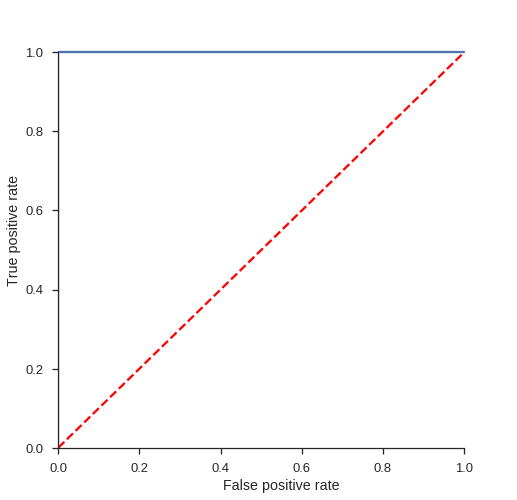

[ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   0.8  0.5  0.4  0.2  0.1  0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  0.90909091  0.90909091  0.7272727

-1.0

In [136]:
auc(y12_test, X12_test, bm_linear12, np.linspace(-10, 10, 100), plot=True)

### 1 vs 3

In [89]:
X13_train = X_train[(y_train==1)|(y_train==3)]
y13_train = y_train[(y_train==1)|(y_train==3)]
y13_train[y13_train==3] = -1
X13_test = X_test[(y_test==1)|(y_test==3)]
y13_test = y_test[(y_test==1)|(y_test==3)]
y13_test[y13_test==3] = -1

print(X13_train)
y13_train

[[-0.15742297  0.14665033 -0.39387685 -0.44199346]
 [-0.32885154 -0.02001634 -0.44650843 -0.4003268 ]
 [-0.27170868  0.14665033 -0.42896457 -0.44199346]
 [-0.24313725  0.31331699 -0.35878913 -0.35866013]
 [-0.30028011  0.02165033 -0.42896457 -0.48366013]
 [-0.41456583 -0.31168301 -0.46405229 -0.4003268 ]
 [-0.44313725 -0.06168301 -0.44650843 -0.44199346]
 [-0.27170868 -0.02001634 -0.41142071 -0.44199346]
 [-0.30028011 -0.02001634 -0.44650843 -0.44199346]
 [-0.24313725  0.31331699 -0.41142071 -0.44199346]
 [-0.15742297  0.35498366 -0.46405229 -0.35866013]
 [-0.27170868  0.22998366 -0.44650843 -0.44199346]
 [-0.35742297  0.06331699 -0.41142071 -0.44199346]
 [-0.21456583  0.43831699 -0.42896457 -0.48366013]
 [-0.30028011  0.02165033 -0.42896457 -0.48366013]
 [-0.07170868  0.56331699 -0.42896457 -0.35866013]
 [-0.27170868  0.18831699 -0.41142071 -0.2753268 ]
 [-0.21456583  0.14665033 -0.44650843 -0.44199346]
 [-0.32885154  0.14665033 -0.41142071 -0.44199346]
 [-0.24313725  0.18831699 -0.44

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

In [137]:
parameters = {
    'kernel_name': ['linear'],
    'C': np.logspace(0, 4, 8),
    'kernelparameter': np.linspace(-10, 10, 8),
}
gs_linear13 = GridSearchCV(svm_smo(kernel='gaussian'), parameters, cv=5,
                           scoring=lambda m, X, y: -zero_one_loss(y, m.predict(X)),
                           verbose=1)
gs_linear13.fit(X13_train, y13_train)
bm_linear13 = gs_linear13.best_estimator_

zero_one_loss(y13_test, bm_linear13.predict(X13_test)), bm_linear13.get_params(True)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.4min finished


(0.0,
 {'C': 1.0, 'kernel_name': 'linear', 'kernelparameter': -7.1428571428571423})

### 2 vs 3

In [91]:
X23_train = X_train[(y_train==2)|(y_train==3)]
y23_train = y_train[(y_train==2)|(y_train==3)]
y23_train[y23_train==2] = 1
y23_train[y23_train==3] = -1
X23_test = X_test[(y_test==2)|(y_test==3)]
y23_test = y_test[(y_test==2)|(y_test==3)]
y23_test[y23_test==2] = 1
y23_test[y23_test==3] = -1

print(X23_train)
y23_train

[[ 0.29971989  0.06331699  0.13243894  0.05800654]
 [ 0.04257703 -0.06168301  0.13243894  0.05800654]
 [ 0.2140056   0.02165033  0.07980736  0.05800654]
 [ 0.04257703 -0.10334967  0.13243894 -0.0253268 ]
 [ 0.0140056  -0.14501634  0.20261438  0.14133987]
 [-0.07170868 -0.10334967  0.09735122  0.01633987]
 [ 0.15686275 -0.10334967  0.11489508  0.0996732 ]
 [-0.10028011 -0.14501634  0.04471964  0.01633987]
 [ 0.0140056  -0.35334967  0.00963192 -0.10866013]
 [-0.12885154 -0.22834967  0.00963192  0.01633987]
 [-0.24313725 -0.22834967 -0.16580667 -0.06699346]
 [ 0.24257703 -0.10334967  0.1499828   0.05800654]
 [-0.30028011 -0.27001634 -0.11317509 -0.10866013]
 [-0.01456583  0.06331699  0.1499828   0.2246732 ]
 [-0.10028011 -0.22834967 -0.00791194 -0.06699346]
 [ 0.04257703 -0.10334967  0.00963192  0.01633987]
 [ 0.0140056   0.14665033  0.09735122  0.14133987]
 [ 0.09971989 -0.31168301  0.07980736  0.01633987]
 [ 0.07114846 -0.35334967  0.09735122  0.0996732 ]
 [ 0.12829132  0.06331699  0.09

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

In [139]:
parameters = {
    'kernel_name': ['linear'],
    'C': np.logspace(0, 4, 8),
    'kernelparameter': np.linspace(-10, 10, 8),
}
gs_linear23 = GridSearchCV(svm_smo(kernel='gaussian'), parameters, cv=5,
                           scoring=lambda m, X, y: -zero_one_loss(y, m.predict(X)),
                           verbose=1)
gs_linear23.fit(X23_train, y23_train)
bm_linear23 = gs_linear23.best_estimator_

zero_one_loss(y23_test, bm_linear23.predict(X23_test)), bm_linear23.get_params(True)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.7min finished


(0.33333333333333337,
 {'C': 3.7275937203149399,
  'kernel_name': 'linear',
  'kernelparameter': 1.4285714285714288})

## Assignment 7

### Point 1.

In [140]:
usps_data = loadmat('./usps.mat')
y = usps_data['data_labels'].T
X = usps_data['data_patterns'].T

indices = np.arange(len(y))
te_indices = []
for i in range(10):
    digit_indices = indices[np.argmax(y, axis=1) == i]
    te_indices.extend(list(
        np.random.choice(digit_indices,
                         len(digit_indices)//4,
                         replace=False)
    ))
te_indices = np.array(te_indices)
tr_indices = indices[~np.isin(indices, te_indices)]
X_train = X[tr_indices]
y_train = y[tr_indices]
X_test = X[te_indices]
y_test = y[te_indices]


X_train = (X_train - X_train.min(axis=0))/(X_train.max(axis=0) - X_train.min(axis=0))
X_test = (X_test - X_test.min(axis=0))/(X_test.max(axis=0) - X_test.min(axis=0))

X_train -= X_train.mean(axis=0)
X_test -= X_test.mean(axis=0)

print(y[:5])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

[[-1 -1 -1 -1 -1 -1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1 -1 -1 -1]]


((1509, 256), (1509, 10), (498, 256), (498, 10))

In [146]:
parameters = [
    {
        'kernel_name': ['linear'],
        'C': np.logspace(0, 4, 5),
        'kernelparameter': np.logspace(-1, 2, 4),
    },
    {
        'kernel_name': ['polynomial'],
        'C': np.logspace(0, 4, 5),
        'kernelparameter': np.logspace(-1, 2, 4),
    },
    {
        'kernel_name': ['gaussian'],
        'C': np.logspace(0, 4, 5),
        'kernelparameter': np.logspace(-1, 2, 4),
    },
]


def cv_digit(i):
    print(f"Training {i}")
    y_tr = (np.argmax(y_train, axis=1) == i).astype(int)
    y_tr[y_tr == 0] = -1

    gs = GridSearchCV(svm_smo('gaussian'), parameters, cv=5, verbose=1,
                      scoring=lambda m, X, y: -zero_one_loss(y, m.predict(X)))
    gs.fit(X_train, y_tr)
    best_model = gs.best_estimator_
    
    y_te = (np.argmax(y_test, axis=1) == i).astype(int)
    y_te[y_te == 0] = -1
    return {
        'model': best_model,
        'params': best_model.get_params(True),
        'error': zero_one_loss(y_te, best_model.predict(X_test))
    }

results = Parallel(n_jobs=-1)(delayed(cv_digit)(i) for i in range(10))

results

Training 4
Training 5
Training 6
Training 1
Training 3
Training 0
Training 7
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training 2
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/home/mtambos/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid val

KeyboardInterrupt: 

In [148]:
parameters = [
    {
        'kernel': ['linear'],
        'C': np.logspace(0, 4, 5),
    },
    {
        'kernel': ['poly'],
        'C': np.logspace(0, 4, 5),
        'degree': np.arange(1, 4),
        'gamma': np.logspace(-1, 2, 4),
        'coef0': np.arange(-2, 3),
    },
    {
        'kernel': ['rbf'],
        'C': np.logspace(0, 4, 5),
        'gamma': np.logspace(-1, 2, 4),
    },
]

results = {}


def zero_one_score(m, X, y):
    return -zero_one_loss(y, m.predict(X))


for i in range(10):
    print(f"Training {i}")
    y_tr = (np.argmax(y_train, axis=1) == i).astype(int)
    y_tr[y_tr == 0] = -1

    gs = GridSearchCV(SVC(), parameters, cv=5, n_jobs=8, verbose=1,
                      scoring=zero_one_score)
    gs.fit(X_train, y_tr)
    best_model = rename_properties(gs.best_estimator_, y_tr)
    
    y_te = (np.argmax(y_test, axis=1) == i).astype(int)
    y_te[y_te == 0] = -1
    results[i] = {
        'model': best_model,
        'params': best_model.get_params(True),
        'error': zero_one_loss(y_te, best_model.predict(X_test))
    }
results

Training 0
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   21.3s
[Parallel(n_jobs=8)]: Done 1551 tasks      | elapsed:   45.8s


Training 1
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 688 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 1610 out of 1625 | elapsed:   41.7s remaining:    0.4s


Training 2
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:   44.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   21.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:  1.1min finished


Training 3
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   20.3s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   43.0s
[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:   57.2s finished


Training 4
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   32.6s


Training 5
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   23.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   37.5s


Training 6
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 688 tasks      | elapsed:   14.5s
[Parallel(n_jobs=8)]: Done 1610 out of 1625 | elapsed:   53.9s remaining:    0.5s


Training 7
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:   57.4s finished
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   32.4s
[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:   47.4s finished


Training 8
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   42.9s


Training 9
Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   20.1s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   43.2s
[Parallel(n_jobs=8)]: Done 1625 out of 1625 | elapsed:   59.5s finished


{0: {'error': 0.0020080321285140812,
  'model': SVC(C=1.0, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape=None, degree=2, gamma=0.10000000000000001,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
  'params': {'C': 1.0,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 1,
   'decision_function_shape': None,
   'degree': 2,
   'gamma': 0.10000000000000001,
   'kernel': 'poly',
   'max_iter': -1,
   'probability': False,
   'random_state': None,
   'shrinking': True,
   'tol': 0.001,
   'verbose': False}},
 1: {'error': 0.0020080321285140812,
  'model': SVC(C=10.0, cache_size=200, class_weight=None, coef0=2,
    decision_function_shape=None, degree=2, gamma=0.10000000000000001,
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
  'params': {'C': 10.0,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 2,
   'decis

In [167]:
models[0].support_vectors_.shape[1]**0.5

16.0

In [163]:
best_params = {
    0: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 1,
        'decision_function_shape': None,
        'degree': 2,
        'gamma': 0.10000000000000001,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    1: {
        'C': 10.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 2,
        'decision_function_shape': None,
        'degree': 2,
        'gamma': 0.10000000000000001,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    2: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 2,
        'decision_function_shape': None,
        'degree': 3,
        'gamma': 1.0,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    3: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 2,
        'decision_function_shape': None,
        'degree': 3,
        'gamma': 0.10000000000000001,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    4: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 1,
        'decision_function_shape': None,
        'degree': 2,
        'gamma': 0.10000000000000001,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    5: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 2,
        'decision_function_shape': None,
        'degree': 2,
        'gamma': 10.0,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    6: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 1,
        'decision_function_shape': None,
        'degree': 3,
        'gamma': 0.10000000000000001,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    7: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 1,
        'decision_function_shape': None,
        'degree': 3,
        'gamma': 1.0,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    8: {
        'C': 1.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 2,
        'decision_function_shape': None,
        'degree': 2,
        'gamma': 10.0,
        'kernel': 'poly',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    },
    9: {
        'C': 10.0,
        'cache_size': 200,
        'class_weight': None,
        'coef0': 0.0,
        'decision_function_shape': None,
        'degree': 3,
        'gamma': 0.10000000000000001,
        'kernel': 'rbf',
        'max_iter': -1,
        'probability': False,
        'random_state': None,
        'shrinking': True,
        'tol': 0.001,
        'verbose': False
    }
}

models = {}
for k, params in best_params.items():
    y_tr = (np.argmax(y_train, axis=1) == i).astype(int)
    y_tr[y_tr == 0] = -1
    model = SVC(**params).fit(X_train, y_tr)
    models[k] = model

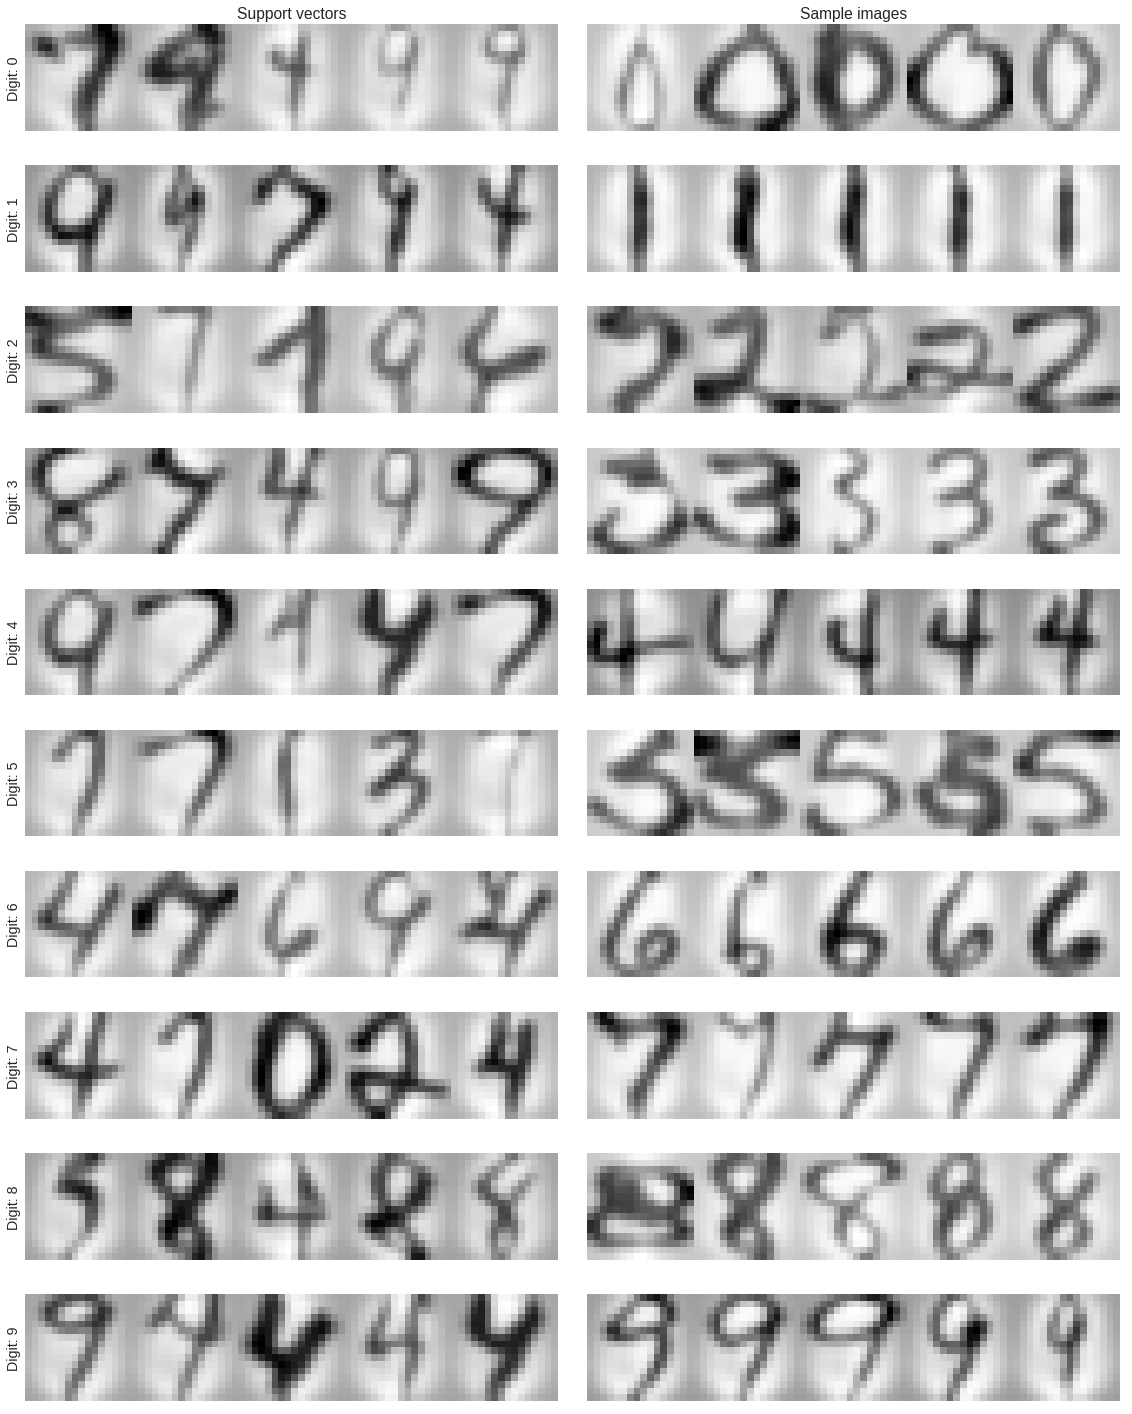

In [196]:
_, axes = plt.subplots(10, 2, figsize=(16, 20))

axes[0][0].set_title("Support vectors")
axes[0][1].set_title("Sample images")
for i, (ax1, ax2) in enumerate(axes):
    sv = models[i].support_vectors_
    indices = np.arange(len(sv))
    indices = np.random.choice(indices, 5, replace=False)
    sv = sv[indices]
    ax1.imshow(sv.reshape(5, 16, 16).transpose(1, 0, 2).reshape(16, 80))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel(f"Digit: {i}")

    sv = X_train[np.argmax(y_train, axis=1)==i]
    indices = np.arange(len(sv))
    indices = np.random.choice(indices, 5, replace=False)
    sv = sv[indices]
    ax2.imshow(sv.reshape(5, 16, 16).transpose(1, 0, 2).reshape(16, 80))
    ax2.set_xticks([])
    ax2.set_yticks([])

sns.despine(left=True, bottom=True)
plt.tight_layout()

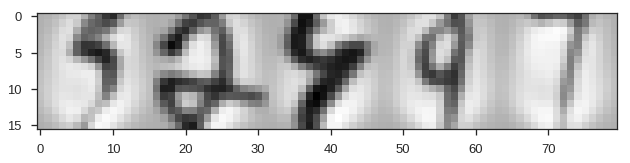

In [171]:
sv = models[0].support_vectors_
indices = np.arange(len(sv))
indices = np.random.choice(indices, 5, replace=False)
sv = sv[indices]
plt.imshow(sv.reshape(5, 16, 16).transpose(1, 0, 2).reshape(16, 80))


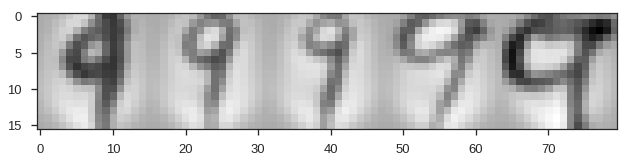

In [184]:
sv = X_train[np.argmax(y_train, axis=1)==]
indices = np.arange(len(sv))
indices = np.random.choice(indices, 5, replace=False)
sv = sv[indices]
plt.imshow(sv.reshape(5, 16, 16).transpose(1, 0, 2).reshape(16, 80))
